In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Conv3DTranspose

import keras
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization
import numpy as np
import pandas as pd
import random
import os
import imageio
import cv2
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import (
    Activation, Add, BatchNormalization, concatenate, Input, Dropout,
    Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, ConvLSTM2D, GlobalAveragePooling2D
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


In [3]:
#initialising the filepath for images
sdcImage_path = ["selfDrivingCarsMask/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
#initialising the filepath for masks
sdcMask_path = ["selfDrivingCarsMask/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [4]:
import os

def get_imgFilePath(filePaths):
    img_filePaths = []
    for filePath in filePaths:
        img_files = os.listdir(filePath)
        for img_file in img_files:
            img_filePaths.append(os.path.join(filePath, img_file))
    return img_filePaths


In [5]:
sdcImage_paths = get_imgFilePath(sdcImage_path)
sdcMask_paths = get_imgFilePath(sdcMask_path)

print("Number of images:", len(sdcImage_paths))
print("Number of masks:", len(sdcMask_paths))

# Print out file paths for images and masks
print("Image file paths:")
print(sdcImage_paths[:5])  # Print the first 5 file paths
print("Mask file paths:")
print(sdcMask_paths[:5])   # Print the first 5 file paths



Number of images: 4588
Number of masks: 4998
Image file paths:
['selfDrivingCarsMask/dataA/dataA/CameraRGB/02_00_000.png', 'selfDrivingCarsMask/dataA/dataA/CameraRGB/02_00_001.png', 'selfDrivingCarsMask/dataA/dataA/CameraRGB/02_00_010.png', 'selfDrivingCarsMask/dataA/dataA/CameraRGB/02_00_011.png', 'selfDrivingCarsMask/dataA/dataA/CameraRGB/02_00_020.png']
Mask file paths:
['selfDrivingCarsMask/dataA/dataA/CameraSeg/02_00_000.png', 'selfDrivingCarsMask/dataA/dataA/CameraSeg/02_00_001.png', 'selfDrivingCarsMask/dataA/dataA/CameraSeg/02_00_010.png', 'selfDrivingCarsMask/dataA/dataA/CameraSeg/02_00_011.png', 'selfDrivingCarsMask/dataA/dataA/CameraSeg/02_00_020.png']


In [6]:
num_sdcImages = len(sdcImage_paths)
num_sdcMasks = len(sdcMask_paths)

print("Total number of images present in the Self-Driving Car dataset:", num_sdcImages)
print("Total number of masks present in the Self-Driving Car dataset:", num_sdcMasks)


Total number of images present in the Self-Driving Car dataset: 4588
Total number of masks present in the Self-Driving Car dataset: 4998


In [7]:
def augumet_preprocess(image_path,mask_path):
    #reading the image file
    img = tf.io.read_file(image_path)
    #decoding the images to ensure the output has 3 color channels
    img = tf.image.decode_png(img, channels=3)
    #converting into float type
    img = tf.image.convert_image_dtype(img, tf.float32)
    #resizing
    img = tf.image.resize(img, (256, 256), method='nearest')

    #reading the image file
    segmented_img = tf.io.read_file(mask_path)
    #decoding the images to ensure the output has 3 color channels
    segmented_img = tf.image.decode_png(segmented_img, channels=3)
    #reducing the number of color channels from 3 to 1
    segmented_img = tf.math.reduce_max(segmented_img, axis=-1, keepdims=True)
    #resizing
    segmented_img = tf.image.resize(segmented_img, (256, 256), method='nearest')
    
    return img,segmented_img

In [8]:
def crop_img(img):
    #initialising a random cropping scale
    crop_value= random.uniform(1, 1.3)
    #resizing
    cropped_img=tf.image.resize(img, (int(256/crop_value), int(256/crop_value)), method='nearest')
    #ensuring correct image size
    cropped_img=tf.image.pad_to_bounding_box(cropped_img, 0, 0, 256, 256)
    return cropped_img

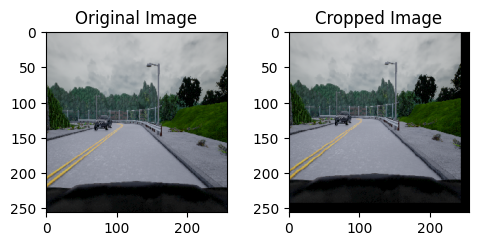

In [9]:
indexed_img = random.randint(0, len(sdcImage_paths) - 1)
img_path = sdcImage_paths[indexed_img]
segImg_path = sdcMask_paths[indexed_img]

og_img, _ = augumet_preprocess(img_path, segImg_path)
cropped_img = crop_img(og_img)

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout()

axs[0].imshow(og_img)
axs[0].set_title('Original Image')

axs[1].imshow(cropped_img)
axs[1].set_title('Cropped Image')

plt.show()


In [10]:
def img_panned(img):
    #initialising panning constant to ensure masks align with original images
    panning = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    #panning using the panning-varaiable
    img = panning.augment_image(img)
    #resizing
    img = tf.image.resize(img, (256, 256), method='nearest')
    return img

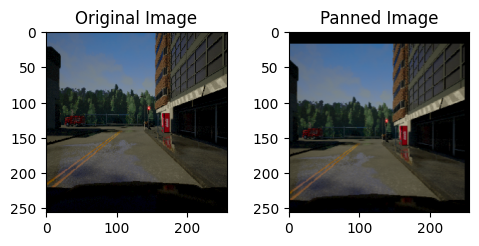

In [11]:
indexed_img = random.randint(0, len(sdcImage_paths) - 1)
img_path = sdcImage_paths[indexed_img]
segImg_path = sdcMask_paths[indexed_img]

og_img, _ = augumet_preprocess(img_path, segImg_path)
og_img_np = og_img.numpy()
panned_img = img_panned(og_img_np)

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout()

axs[0].imshow(og_img_np)
axs[0].set_title('Original Image')

axs[1].imshow(panned_img)
axs[1].set_title('Panned Image')

plt.show()


In [12]:
from PIL import Image

def adjust_brightness_img(img):
    # Convert PIL Image to numpy array
    img_np = np.array(img)

    # Initialize brightness adjustment
    brightness_value = iaa.Multiply((0.2, 1.2))# multiplication factors are less than 1 hence brightness 
    #is reduced for normalization and to enhance contrast

    # Apply brightness adjustment
    img_np = brightness_value.augment_image(img_np)

    # Resize image
    img = tf.image.resize(img_np, (256, 256), method='nearest')

    return img


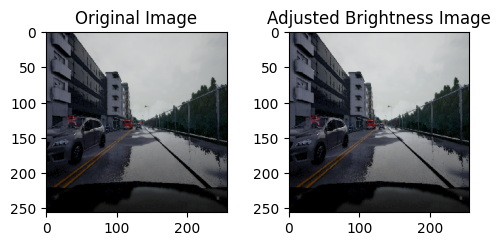

In [13]:
indexed_img = random.randint(0, len(sdcImage_paths) - 1)
img_path = sdcImage_paths[indexed_img]
segImg_path = sdcMask_paths[indexed_img]

og_img, _ = augumet_preprocess(img_path, segImg_path)
og_img_np = og_img.numpy()
adjusted_brightness_image = adjust_brightness_img(og_img_np)

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout()

axs[0].imshow(og_img_np)
axs[0].set_title('Original Image')

axs[1].imshow(adjusted_brightness_image)
axs[1].set_title('Adjusted Brightness Image')

plt.show()


In [14]:
def img_augmentation(img):
    #panning
    if np.random.rand() < 0.5:
        img = img_panned(img)
    #cropping
    if np.random.rand() < 0.5:
        img = crop_img(img)
    #brightess-adjustment
    if np.random.rand() < 0.5:
        img = adjust_brightness_img(img)
    #resizing
    img = tf.image.resize(img, (256, 256), method='nearest')
    return img

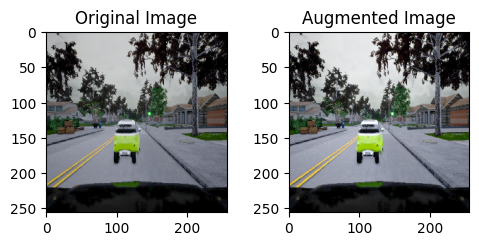

In [15]:
indexed_img = random.randint(0, len(sdcImage_paths) - 1)
img_path = sdcImage_paths[indexed_img]
segImg_path = sdcMask_paths[indexed_img]

og_img, _ = augumet_preprocess(img_path, segImg_path)
og_img_np = og_img.numpy()

# Convert image to uint8 and ensure it's in the range [0, 255]
og_img_np_uint8 = (og_img_np * 255).astype(np.uint8)

augmented_img = img_augmentation(og_img_np_uint8)  # Pass the uint8 image to the function

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout()

axs[0].imshow(og_img_np)
axs[0].set_title('Original Image')

axs[1].imshow(augmented_img)
axs[1].set_title('Augmented Image')
plt.show()



In [16]:
#initialising file paths arrays for images and segemented images.
img_paths = []
segmentImg_paths = []

for img_fp in ['dataA','dataB', 'dataC', 'dataD', 'dataE']:
    img_pathDirectory = 'selfDrivingCarsMask/' + img_fp + '/' + img_fp + '/' + 'CameraRGB'
    segmentedImg_pathDirectory = 'selfDrivingCarsMask/' + img_fp+ '/' + img_fp + '/' + 'CameraSeg'

    for dirname, _, filenames in os.walk(img_pathDirectory):        
        for file_name in filenames:
            image_path = img_pathDirectory + '/' + file_name
            img_paths.append(image_path)
            segmentImage_path = segmentedImg_pathDirectory + '/' + file_name
            segmentImg_paths.append(segmentImage_path)

In [17]:
def load_resize_img(fl_path, fil_path):
    # Load the image using OpenCV
    img = cv2.imread(fl_path)
    if img is None:
        raise ValueError(f"Failed to load image from path: {fl_path}")

    # Convert the image to the appropriate data type
    img = np.array(img, dtype=np.float32)

    # Resize the image
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    
    # Load and resize the segmented image
    segmentImg = cv2.imread(fil_path)
    if segmentImg is None:
        raise ValueError(f"Failed to load segmented image from path: {fil_path}")
    
    # Convert the segmented image to the appropriate data type
    segmentImg = np.array(segmentImg, dtype=np.float32)

    # Resize the segmented image
    segmentImg = cv2.resize(segmentImg, (224, 224), interpolation=cv2.INTER_AREA)

    return img, segmentImg


In [18]:
#function to read the segmented images and identify the road as binary mask of 1
def segmentImg_road(segmentImg):
    segmentImg_road = np.zeros((224, 224, 1), dtype=np.int8)
    segmentImg_road[np.where(segmentImg==7)[0], np.where(segmentImg==7)[1]] = 1
    return np.array(segmentImg_road)

In [19]:
#function combining the before functions to preprocess the images
def preprocess_images(X_path, y_path):
    img_RGB,segmented_img = load_resize_img(X_path,y_path)
    road_segmented_img = segmentImg_road(segmented_img)
    return img_RGB, road_segmented_img

In [20]:


def images_info(img_paths,segImg_paths):
    img = np.zeros((len(img_paths), 224, 224, 3), dtype=np.int16)
    road_segmented_img = np.zeros((len(img_paths), 224, 224, 1), dtype=np.int8)
    for img_index in range(len(img_paths)):
        X_path, y_path = img_paths[img_index], segImg_paths[img_index]
        img[img_index], road_segmented_img[img_index] = preprocess_images(X_path, y_path)
    return img, road_segmented_img

In [21]:
#loading all the images and its information
X_imgs, y_labels = images_info(img_paths,segmentImg_paths)

In [22]:
#spliting the data using train_test_splitfunction 
X_trainVal, X_testVal, y_trainVal, y_testVal = train_test_split(X_imgs, y_labels, 
                                                                test_size=0.2, shuffle =True,random_state=42)
X_trainVal, X_validVal, y_trainVal, y_validVal = train_test_split(X_trainVal, y_trainVal, 
                                                                  test_size=0.175, shuffle =True,random_state=42)

#printing the number of images in each set
print('Number of Semantic_seg_Train_images:',len(X_trainVal))
print('Number of Semantic_seg_Test_Images:',len(X_testVal))
print('Number of Semantic_seg_Validate_Images:',len(X_validVal))

Number of Semantic_seg_Train_images: 3026
Number of Semantic_seg_Test_Images: 918
Number of Semantic_seg_Validate_Images: 643


In [23]:
#calculating the range of labels in training set
unique, count_value = np.unique(y_trainVal, return_counts=True)
print("Training labels: {}".format(dict(zip(unique, count_value))))

#calculating the range of labels in testing set
unique, count_value = np.unique(y_testVal, return_counts=True)
print("Testing labels: {}".format(dict(zip(unique, count_value))))

#calculating the range of labels in validation set
unique, count_value = np.unique(y_validVal, return_counts=True)
print("Validation labels: {}".format(dict(zip(unique, count_value))))

Training labels: {0: 134615690, 1: 17216886}
Testing labels: {0: 40874499, 1: 5187069}
Validation labels: {0: 28596347, 1: 3666821}


In [24]:
#printing shapes of values
print('Shape of Train_images:',X_trainVal.shape)
print('Shape of Train_Label:',y_trainVal.shape)
print('Shape of Test_Images:',X_testVal.shape)
print('Shape of Test_Label:',y_testVal.shape)
print('Shape of Validate_Images:',X_validVal.shape)
print('Shape of Validate_Label:',y_validVal.shape)

Shape of Train_images: (3026, 224, 224, 3)
Shape of Train_Label: (3026, 224, 224, 1)
Shape of Test_Images: (918, 224, 224, 3)
Shape of Test_Label: (918, 224, 224, 1)
Shape of Validate_Images: (643, 224, 224, 3)
Shape of Validate_Label: (643, 224, 224, 1)


In [25]:
# Function to perform semantic segmentation 
def semantic_segmentation(mask_image, num_colors=10):
    
    colors = np.random.randint(0, 256, (num_colors, 3))

    
    segmented_image = colors[mask_image]

    return segmented_image


def create_segmented_video(sdcImage_paths, sdcMask_paths, output_video_file, start_index=0, end_index=100, frame_rate=10):
    # Set the number of samples
    num_ImgSamples = len(sdcImage_paths)

    # Set the start and end index
    start_index = max(0, min(start_index, num_ImgSamples - 1))
    end_index = max(start_index, min(end_index, num_ImgSamples))

    # Read dimensions of the first image
    img_preview = cv2.imread(sdcImage_paths[start_index])
    height, width, _ = img_preview.shape

    # Define the VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Code for mp4 format
    out = cv2.VideoWriter(output_video_file, fourcc, frame_rate, (width, height))  

    # Iterate over the images in the specified range
    for idx in range(start_index, end_index):
        # Read the image and mask
        img_preview = cv2.imread(sdcImage_paths[idx])
        mask_preview = cv2.imread(sdcMask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Perform semantic segmentation
        segmented_img = semantic_segmentation(mask_preview)

        # Write the segmented image to the video
        out.write(segmented_img.astype(np.uint8))

    # Release the VideoWriter object
    out.release()

    print("Segmented video saved as:", output_video_file)

# Specify the output video file
segmented_video_output_file = 'segmented_video_continuous.mp4'

# Define the range of images to consider
start_index = 0
end_index = min(len(sdcImage_paths), start_index + 100)  # Consider 100 images

# Create segmented video 
create_segmented_video(sdcImage_paths, sdcMask_paths, segmented_video_output_file, start_index, end_index, frame_rate=10)

Segmented video saved as: segmented_video_continuous.mp4


In [26]:
#function to tabluate results of model
def tabluate_result(history):
    return pd.DataFrame(history.history)

In [27]:
#function to tabluate mean-results of model
def training_mean_results(history):
    return pd.DataFrame(tabluate_result(history).mean(), columns=['Value']).style.set_caption('Training Mean')

In [28]:
input_shape = (224, 224, 3)
num_classes = 2

# encoder-architecture
inputs = Input(shape=input_shape)
x_layer = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
x_layer = MaxPooling2D((2, 2), padding='same')(x_layer)
encoded = x_layer

# decoder-architecture
x_layer = UpSampling2D((2, 2))(encoded)
x_layer = Conv2D(8, (3, 3), activation='relu', padding='same')(x_layer)
decoded = Conv2D(num_classes, (3, 3), padding='same')(x_layer)
output = Activation('softmax')(decoded)

# Initializing the baseline-autoencoder model
baseline_autoencoder = Model(inputs, output)

# Compiling model
baseline_autoencoder.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy', tf.keras.metrics.OneHotMeanIoU(num_classes=2)])

# Summary of the model
baseline_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 224, 224, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 2)    │           146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954 (3.73 KB)

 Trainable params: 954 (3.73 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#running the model through fit function
baseline_autoencoder_result = baseline_autoencoder.fit(X_trainVal, y_trainVal,
                                                       validation_data=(X_validVal, y_validVal),
                                                       epochs=10,batch_size=64)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 53s 913ms/step - accuracy: 0.5471 - loss: 60.1546 - one_hot_mean_io_u: 0.2798 - val_accuracy: 0.6166 - val_loss: 3.4629 - val_one_hot_mean_io_u: 0.3220
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 949ms/step - accuracy: 0.7589 - loss: 2.2263 - one_hot_mean_io_u: 0.4272 - val_accuracy: 0.8160 - val_loss: 1.4213 - val_one_hot_mean_io_u: 0.4625
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 954ms/step - accuracy: 0.8053 - loss: 1.3226 - one_hot_mean_io_u: 0.4558 - val_accuracy: 0.8100 - val_loss: 1.1289 - val_one_hot_mean_io_u: 0.4519
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 475ms/step - accuracy: 0.8172 - loss: 1.0630 - one_hot_mean_io_u: 0.4564 - val_accuracy: 0.8280 - val_loss: 0.9429 - val_one_hot_mean_io_u: 0.4637
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 501ms/step - accuracy: 0.8309 - loss: 0.9054 - one_hot_mean_io_u: 0.4653 - val_accuracy: 0.8459 - val_loss: 0.7865 - val_one_hot_mean_io_u: 0.4736
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - ac

In [30]:
tabluate_result(baseline_autoencoder_result)

,accuracy,loss,one_hot_mean_io_u,val_accuracy,val_loss,val_one_hot_mean_io_u
0,0.743837,25.026146,0.409065,0.616606,3.462873,0.321970
1,0.777776,1.857089,0.441541,0.816025,1.421299,0.462535
2,0.806181,1.253485,0.454909,0.809959,1.128944,0.451926
3,0.821866,1.022878,0.460046,0.827999,0.942936,0.463719
4,0.833347,0.869258,0.466623,0.845923,0.786463,0.473563
5,0.852537,0.701694,0.473697,0.861504,0.641511,0.478580
6,0.857983,0.603808,0.472831,0.858755,0.562384,0.471263
7,0.860669,0.536296,0.468251,0.864015,0.504504,0.469937
8,0.863494,0.497834,0.462817,0.862368,0.483142,0.464976
9,0.864374,0.476889,0.460642,0.862070,0.460348,0.456628


In [31]:
training_mean_results(baseline_autoencoder_result)

,Value
accuracy,0.828206
loss,3.284538
one_hot_mean_io_u,0.457042
val_accuracy,0.822522
val_loss,1.039440
val_one_hot_mean_io_u,0.451510


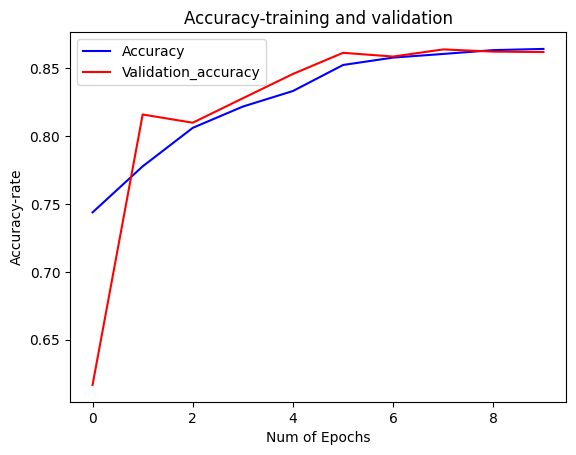

In [32]:
#accuracy-graphplot
plt.plot(baseline_autoencoder_result.history['accuracy'],'b')
plt.plot(baseline_autoencoder_result.history['val_accuracy'],'r')
#graph-title
plt.title('Accuracy-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['Accuracy', 'Validation_accuracy'])

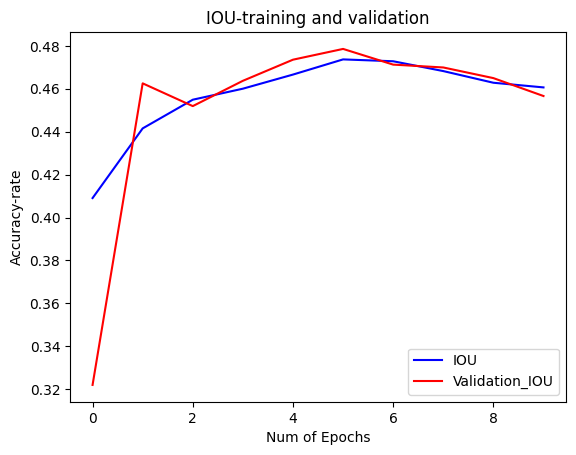

In [33]:
#iou-graphplot
plt.plot(baseline_autoencoder_result.history['one_hot_mean_io_u'],'b')
plt.plot(baseline_autoencoder_result.history['val_one_hot_mean_io_u'],'r')
#graph-title
plt.title('IOU-training and validation')
#graph-xaxisLabel
plt.xlabel('Num of Epochs')
#graph-yaxislabel
plt.ylabel('Accuracy-rate')
#graph-key/legend
plt.legend(['IOU', 'Validation_IOU'])

In [34]:
# Evaluate the model on the testing data
loss_testing, accur_testing, IOU_testing = baseline_autoencoder.evaluate(X_testVal, y_testVal)

# Print the testing results
print("Baseline model:Loss on testing data: ", loss_testing)
print("Baseline model:Accuracy on testing data: ", accur_testing)
print("Baseline model:IOU on testing data: ", IOU_testing)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.8630 - loss: 0.4704 - one_hot_mean_io_u: 0.4548
Baseline model:Loss on testing data:  0.4641609489917755
Baseline model:Accuracy on testing data:  0.8634026646614075
Baseline model:IOU on testing data:  0.4548948109149933


In [35]:
input_shape = (224, 224, 3)  
num_classes = 2

#encoder-architecture
inputs = Input(shape=input_shape)
x_layer = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
x_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = MaxPooling2D((2, 2), padding='same')(x_layer)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(x_layer)
encoded = MaxPooling2D((2, 2), padding='same')(x_layer)

#decoder-architecture
x_layer = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x_layer = Conv2D(256, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = UpSampling2D((2, 2))(x_layer)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = Conv2D(128, (3, 3), activation='relu', padding='same')(x_layer)
x_layer = UpSampling2D((2, 2))(x_layer)
decoded = Conv2D(num_classes, (3, 3), padding='same')(x_layer)
output = Activation('softmax') (decoded)
#Initilaing the improved-autoencoder model
improved_autoencoder = Model(inputs, output)
#Compling model
improved_autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                             metrics=['accuracy', tf.keras.metrics.OneHotMeanIoU(num_classes=2)])

#summary of the model
improved_autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 2)    │         2,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,338 (6.07 MB)

 Trainable params: 1,590,338 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
import pickle

# Function to save data as pickle files
def save_as_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Save X_trainVal, X_testVal, X_validVal as pickle files
save_as_pickle(X_trainVal, 'X_trainVal.pkl')
save_as_pickle(X_testVal, 'X_testVal.pkl')
save_as_pickle(X_validVal, 'X_validVal.pkl')

# Save y_trainVal, y_testVal, y_validVal as pickle files
save_as_pickle(y_trainVal, 'y_trainVal.pkl')
save_as_pickle(y_testVal, 'y_testVal.pkl')
save_as_pickle(y_validVal, 'y_validVal.pkl')

print("Pickle files saved successfully.")


Pickle files saved successfully.
